In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
trainImages = open(os.getcwd() + "/data/MINST/Fashion/train-images-idx3-ubyte", 'rb')
trainLabels = open(os.getcwd() + "/data/MINST/Fashion/train-labels-idx1-ubyte", 'rb')
testImages = open(os.getcwd() + "/data/MINST/Fashion/t10k-images-idx3-ubyte", 'rb')
testLabels = open(os.getcwd() + "/data/MINST/Fashion/t10k-labels-idx1-ubyte", 'rb')

In [3]:
assert(int.from_bytes(trainLabels.read(4), 'big') == 2049)
assert(int.from_bytes(trainImages.read(4), 'big') == 2051)
assert(int.from_bytes(testLabels.read(4), 'big') == 2049)
assert(int.from_bytes(testImages.read(4), 'big') == 2051)

In [4]:
X_train = np.zeros((int.from_bytes(trainImages.read(4), 'big'), int.from_bytes(trainImages.read(4), 'big'), int.from_bytes(trainImages.read(4), 'big')), dtype=np.float32)
Y_train = np.zeros((int.from_bytes(trainLabels.read(4), 'big'), 1), dtype=np.float32)

In [5]:
X_test = np.zeros((int.from_bytes(testImages.read(4), 'big'), int.from_bytes(testImages.read(4), 'big'), int.from_bytes(testImages.read(4), 'big')), dtype=np.float32)
Y_test = np.zeros((int.from_bytes(testLabels.read(4), 'big'), 1), dtype=np.float32)

In [6]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(60000, 28, 28)
(60000, 1)
(10000, 28, 28)
(10000, 1)


In [7]:
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        for k in range(X_train.shape[2]):
            X_train[i,j,k] = float(int.from_bytes(trainImages.read(1), 'big'))
    Y_train[i] = float(int.from_bytes(trainLabels.read(1), 'big'))

for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        for k in range(X_test.shape[2]):
            X_test[i,j,k] = float(int.from_bytes(testImages.read(1), 'big'))
    Y_test[i] = float(int.from_bytes(testLabels.read(1), 'big'))

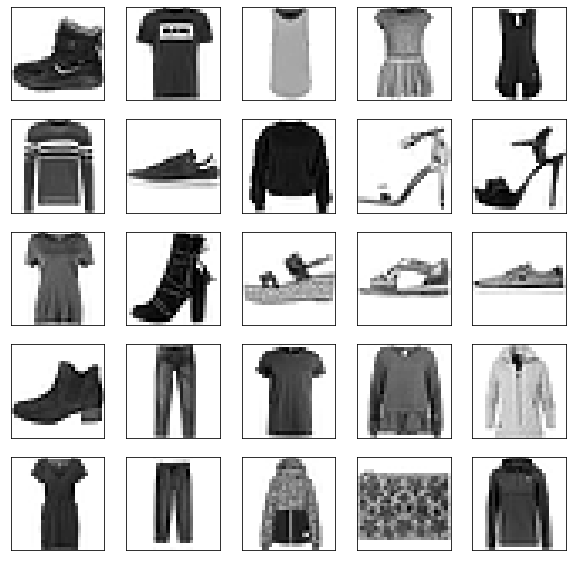

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
plt.show()

In [9]:
X_train = tf.convert_to_tensor(X_train,dtype=tf.float32)/255.0
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)/255.0

In [10]:
X_train = tf.reshape(X_train, shape=(X_train.shape[0], 28,28,1))
X_test = tf.reshape(X_test, shape=(X_test.shape[0], 28,28,1))
X_train.shape, X_test.shape

(TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

In [11]:
Y_train = tf.keras.utils.to_categorical(Y_train,num_classes=10)
Y_test = tf.keras.utils.to_categorical(Y_test,num_classes=10)

In [12]:
Y_train.shape, Y_test.shape

((60000, 10), (10000, 10))

In [13]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [26]:
def convModel(input_shape):
    XIn = keras.Input(shape=input_shape)

    X = keras.layers.Convolution2D(64, 3, strides=(1,1), padding='valid', data_format='channels_last',input_shape=input_shape, activation='relu', name='Conv0')(XIn)
    X = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2),name='P0')(X)

    X = keras.layers.Convolution2D(128,3, activation='relu', name='Conv1')(X)
    X = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2),name='P1')(X)

    X= keras.layers.Flatten()(X)

    X = keras.layers.Dense(1600,activation='relu', name='FC2')(X)

    X = keras.layers.Dense(10,activation='softmax', name='FC3')(X)

    model = tf.keras.Model(inputs=XIn, outputs= X)

    return model

In [27]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=0,min_delta=0.0001)

In [38]:
model1 = convModel(X_train.shape[1:])
model1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv0 (Conv2D)               (None, 26, 26, 64)        640       
_________________________________________________________________
P0 (MaxPooling2D)            (None, 13, 13, 64)        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 11, 11, 128)       73856     
_________________________________________________________________
P1 (MaxPooling2D)            (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
FC2 (Dense)                  (None, 1600)              5121

In [39]:
model1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
print(X_train.shape)
history = model1.fit(X_train,Y_train, epochs=50, batch_size = 50000, validation_data=(X_test, Y_test),validation_freq=1, callbacks=[earlystop_callback])

(60000, 28, 28, 1)
Epoch 1/50


ResourceExhaustedError:  OOM when allocating tensor with shape[50000,64,26,26] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_2/Conv0/Conv2D (defined at <ipython-input-52-cad731a4dba5>:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_70672]

Function call stack:
train_function


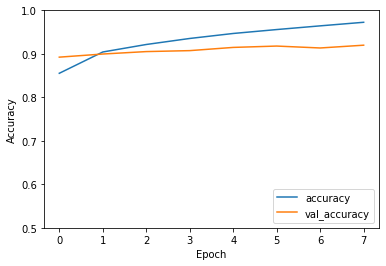

In [41]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

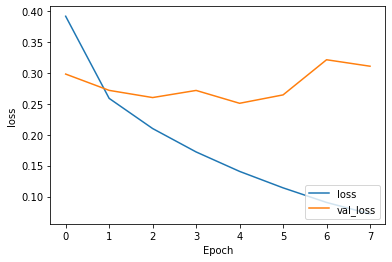

In [42]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')

In [43]:
model1.evaluate(X_test,Y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3107 - accuracy: 0.9199


[0.3106749355792999, 0.9199000000953674]

In [44]:
predictions = tf.argmax(model1.predict(X_test), axis=1)

In [45]:
from sklearn.metrics import f1_score, recall_score, precision_score

In [46]:
labels = tf.argmax(Y_test, axis=1)

In [47]:
confusion_matrix = tf.math.confusion_matrix(labels, predictions)
f1 = f1_score(labels, predictions, average='macro')
recall = recall_score(labels, predictions, average='macro')
precision = precision_score(labels, predictions, average='macro')
confusion_matrix, f1, recall, precision

(<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
 array([[874,   2,  26,  10,   4,   0,  79,   0,   5,   0],
        [  2, 985,   0,   8,   3,   0,   1,   0,   1,   0],
        [ 16,   0, 897,   7,  47,   0,  32,   0,   1,   0],
        [ 24,   6,  12, 916,  24,   0,  16,   0,   2,   0],
        [  1,   0,  51,  18, 900,   0,  30,   0,   0,   0],
        [  0,   0,   0,   0,   0, 984,   0,  14,   0,   2],
        [103,   2,  66,  18,  78,   0, 726,   0,   7,   0],
        [  0,   0,   0,   0,   0,   6,   0, 984,   0,  10],
        [  3,   0,  10,   2,   3,   2,   3,   1, 976,   0],
        [  0,   0,   1,   0,   0,   5,   0,  37,   0, 957]], dtype=int32)>,
 0.9194611626167012,
 0.9199000000000002,
 0.9200389060650146)

In [60]:
def train_mnist_conv():
    # Please write your code only where you are indicated.
    # please do not remove model fitting inline comments.

    # YOUR CODE STARTS HERE
    class EarlyStoppingAtMinLoss(tf.keras.callbacks.Callback):
        def __init__(self, patience=0):
            super(EarlyStoppingAtMinLoss, self).__init__()
            self.patience = patience
            # best_weights to store the weights at which the minimum loss occurs.
            self.best_weights = None

        def on_train_begin(self, logs=None):
            # The number of epoch it has waited when loss is no longer minimum.
            self.wait = 0
            # The epoch the training stops at.
            self.stopped_epoch = 0
            # Initialize the best as infinity.
            self.best = np.Inf

        def on_epoch_end(self, epoch, logs=None):
            current = logs.get("loss")
            if np.less(current, self.best):
                self.best = current
                self.wait = 0
                # Record the best weights if current results is better (less).
                self.best_weights = self.model.get_weights()
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch
                    self.model.stop_training = True
                    print("Restoring model weights from the end of the best epoch.")
                    self.model.set_weights(self.best_weights)

        def on_train_end(self, logs=None):
            if self.stopped_epoch > 0:
                print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

    # YOUR CODE ENDS HERE

    mnist = tf.keras.datasets.mnist
    (training_images, training_labels), (test_images, test_labels) = mnist.load_data(path=os.getcwd() + '/data/MINST/Fashion/mnist.npz')
    # YOUR CODE STARTS HERE
    x_train = training_images/255.0
    x_train = np.reshape(x_train, (x_train.shape[0], 28, 28,1))
    x_test = test_images/255.0
    x_test = np.reshape(x_test, (x_test.shape[0], 28, 28, 1))
    stopping = EarlyStoppingAtMinLoss(patience = 2)
    # YOUR CODE ENDS HERE

    model = tf.keras.models.Sequential([
            tf.keras.layers.Convolution2D(filters = 64, kernel_size = 3, strides = (1,1), input_shape = (28,28,1), activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Convolution2D(filters = 128, kernel_size = 3, strides = (1,1), activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units = 1600, activation = 'relu'),
            tf.keras.layers.Dense(units=10, activation='softmax'),
            # YOUR CODE ENDS HERE
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # model fitting
    history = model.fit(x= x_train, y = training_labels, epochs = 20, validation_data=(x_test, test_labels), callbacks=[stopping])
    # model fitting
    return history, model

In [61]:
history, model = train_mnist_conv()

Epoch 1/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0964 - accuracy: 0.9706 - val_loss: 0.0433 - val_accuracy: 0.9858
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0356 - accuracy: 0.9884 - val_loss: 0.0327 - val_accuracy: 0.9895
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0225 - accuracy: 0.9925 - val_loss: 0.0300 - val_accuracy: 0.9910
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0170 - accuracy: 0.9945 - val_loss: 0.0385 - val_accuracy: 0.9887
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0127 - accuracy: 0.9961 - val_loss: 0.0314 - val_accuracy: 0.9907
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0118 - accuracy: 0.9964 - val_loss: 0.0491 - val_accuracy: 0.9886
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0087 - accuracy: 0.9974 - val_loss: 0.0281 - val_accuracy:

In [62]:
model.evaluate(x=x_test, y=y_test)

NameError: name 'x_test' is not defined

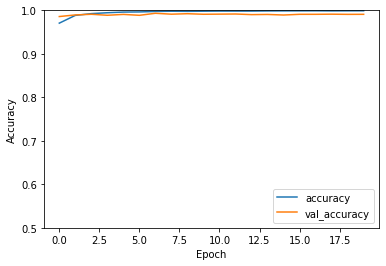

In [65]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

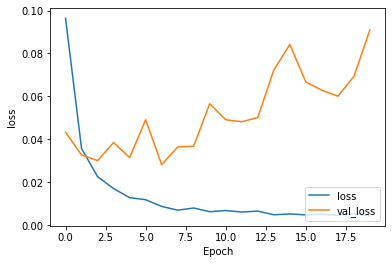

In [66]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')